In [1]:
import tensorflow

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def download_images():
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/test_images/'
    filenames = ['image1.jpg', 'image2.jpg']
    image_paths = []
    for filename in filenames:
        image_path = tf.keras.utils.get_file(fname=filename,
                                            origin=base_url + filename,
                                            untar=False)
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
        
    image_paths.append('C:\\Users\\herrj\\Downloads\\image0.jpg')
    return image_paths

IMAGE_PATHS = download_images()

print(IMAGE_PATHS)

['C:\\Users\\herrj\\.keras\\datasets\\image1.jpg', 'C:\\Users\\herrj\\.keras\\datasets\\image2.jpg', 'C:\\Users\\herrj\\Downloads\\image0.jpg']


In [3]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'faster_rcnn_resnet50_v1_1024x1024_coco17_tpu-8'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

In [4]:
# Download labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

In [5]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 26.216927528381348 seconds


In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

In [24]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

Running inference for C:\Users\herrj\.keras\datasets\image1.jpg... [0, 1, 2, 3, 4, 5, 6, 7]
[18 18 19  1  1  1  1  1 19 18  1  1 18  1 18 19  1 18  1 87 31 21  1  1
 18  1 18 87 19  1 18 19 62 19 87  1  1  1 19  1  1 19 18 18 62 31 62  1
 21 40 19 27 21 19 19  1 21  1 18 43 21 18 62 21 21 18 19 31 18  1 48  1
 19 17 15  1 62 65 18  1 87 21  3 21 62 17 19  1 19 44  3 19 88 51 18 19
 62  1 25 63  1  1 16 77 18 31 87 20 18  1  2 20 21 62 62 18  3  1 19 19
 63 61  1  1 17 50 21  3 18 62 21 21 19 65 21 19 67 48  1 18 21  1 20 22
 18 87 28 21 31 43  3 63 63 21 18 21 18  1 62 20 19 15  2 88 27 87 63 50
 17 32 33 62 49 43 22 18 62 25 22 22 62 28 63 31 88 15 87 33 62 27 41 88
 25 63 44 19 41 20 48 62 20 27 84 62 67  1 47 28 62 18 16 18 17 62 18 48
 62 62 19  1 20 70 62 15 19 60  3 48 32 21 62 15  3  3 20 33  3 19 25 15
 28 28 65 19  6 63 89 62 33 44 21 33 21  4 86 62  8 25 18 31 22 41 87 62
 65 19 49 46 31 25 22  9 16 18 63 43 42 41 32 15 63 73 15 18 87 25 32 23
 63 88  3 62 17 67 17 27 19 86 1

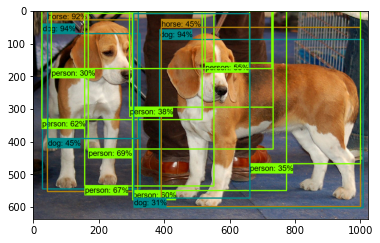

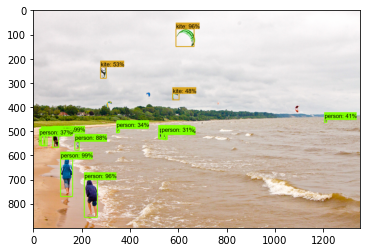

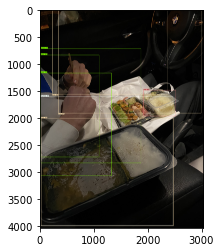

In [37]:
for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    indices = [i for i, x in enumerate(detections['detection_scores']) if x >= 0.5]
    print(indices)
    print(detections['detection_classes'])
    
    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2

## Tensorflow lite

In [8]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(PATH_TO_SAVED_MODEL) # path to the SavedModel directory
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Save the model.
with open('../models/' + MODEL_NAME + '.tflite', 'wb') as f:
  f.write(tflite_model)